In [1]:
import numpy as np
from data_generation_sty import GaussianDataGenerator
from sklearn.linear_model import Lasso

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import pickle as pkl

import pandas as pd
from concurrent.futures import ThreadPoolExecutor
import os
from matplotlib import pyplot as plt
import glob
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [12]:
N = 1000
d = 400
m = 40
noise_level_lst = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
trial_num = 10
cv_num = 5

alpha_lst = np.logspace(-7, -2, 100)

In [13]:
seed = 0
Data_Geneartor = GaussianDataGenerator(N, d, m, 0.3, seed)

true_signal, dictionary, true_indices, true_coefficients, perturbed_signal = Data_Geneartor.shuffle()

In [14]:
test_lasso = Lasso(alpha=0.1, max_iter=10000, tol=0.0001)
test_lasso.fit(dictionary, perturbed_signal)

y_pred = test_lasso.predict(dictionary)
mse = mean_squared_error(perturbed_signal, y_pred)
mse

0.21633251606542714

In [15]:
lasso_cv = GridSearchCV(Lasso(), {'alpha': alpha_lst}, cv=cv_num, scoring='neg_mean_squared_error')

lasso_cv.fit(dictionary, perturbed_signal)

-lasso_cv.cv_results_['mean_test_score']

array([0.36869622, 0.35497701, 0.33370906, 0.32282934, 0.31852529,
       0.31382362, 0.3088596 , 0.30372739, 0.29831182, 0.29274471,
       0.28675744, 0.28042926, 0.27421145, 0.26765411, 0.26139669,
       0.25495494, 0.24822358, 0.24205646, 0.23570726, 0.22966052,
       0.22373297, 0.21862346, 0.21336097, 0.20877164, 0.204828  ,
       0.20192237, 0.20021358, 0.1994368 , 0.19850574, 0.19766568,
       0.19662563, 0.19477638, 0.19416566, 0.19370837, 0.19393773,
       0.19481398, 0.19603079, 0.1971438 , 0.19810382, 0.19900934,
       0.19962186, 0.20027751, 0.20079953, 0.20112193, 0.2012156 ,
       0.20126368, 0.20120425, 0.20105627, 0.20081495, 0.20033621,
       0.19953156, 0.19875702, 0.1982501 , 0.19745819, 0.19656555,
       0.1949328 , 0.19300739, 0.19131428, 0.18947909, 0.18724847,
       0.18499032, 0.18277853, 0.18045801, 0.17767299, 0.17496356,
       0.17175346, 0.16850358, 0.16519352, 0.16175811, 0.15846193,
       0.15573873, 0.15309295, 0.15052001, 0.14826246, 0.14588

In [16]:
lasso_cv.best_params_

{'alpha': 0.0012328467394420659}

Ready to calculate baseline performance

In [17]:
def cv_lasso_best_perfromance(N, d, m, noise_level_lst, cv_num, alpha_lst, trial_num, output_filename = None):
    if not os.path.exists('./memory_lasso'):
        os.mkdir('./memory_lasso')
    if output_filename is None:
        output_filename = 'Lasso' + str(N) + '_' + str(d) + '_' + str(m) + '_' + str(trial_num) + '_' + str(cv_num) + '.pkl'
    res_log = {
        'parameters': {'N': N, 'd': d, 'm': m, 'noise_level_lst': noise_level_lst, 'cv_num': cv_num, 'trial_num': trial_num, 'alpha_lst': alpha_lst},
        'noise_level_best_alpha': [],
        'noise_level_lowest_MSE': [],
        'log': []
    }
    noise_level_best_alpha = []
    noise_level_lowest_MSE = []
    lasso_cv_tmp = GridSearchCV(Lasso(), {'alpha': alpha_lst}, cv=cv_num, scoring='neg_mean_squared_error')
    for noise_level in noise_level_lst:
        print("Cross validating alpha under noise level: ", noise_level)
        trials_best_alpha_tmp = []
        trials_loweset_MSE_temp = []
        for trial in range(trial_num):
            Data_Geneartor = GaussianDataGenerator(N, d, m, noise_level, trial)
            true_signal, dictionary, true_indices, true_coefficients, perturbed_signal = Data_Geneartor.shuffle()
            # TODO: 
            lasso_cv_tmp.fit(dictionary, perturbed_signal)
            cv_err_lst = -lasso_cv_tmp.cv_results_['mean_test_score']
            lowest_error = np.min(cv_err_lst)
            lowest_error_alpha = lasso_cv_tmp.best_params_['alpha']
            trials_best_alpha_tmp.append(lowest_error_alpha)
            trials_loweset_MSE_temp.append(lowest_error)
            print("Trial: ", trial, " Best alpha: ", lowest_error_alpha, " Lowest Error: ", lowest_error)
            log_tmp = {'noise_level': noise_level, 'trial': trial, 'data': Data_Geneartor, 'cv_error_lst': cv_err_lst, 
                       'lowest_error': lowest_error, 'lowest_error_K': lowest_error_alpha}
            res_log['log'].append(log_tmp)
        noise_level_best_alpha.append(np.mean(trials_best_alpha_tmp))
        noise_level_lowest_MSE.append(np.mean(trials_loweset_MSE_temp))
        print("Average best K for noise level: ", noise_level, " is: ", np.mean(trials_best_alpha_tmp), " with MSE: ", np.mean(trials_loweset_MSE_temp))
    res_log['noise_level_best_alpha'] = noise_level_best_alpha
    res_log['noise_level_lowest_MSE'] = noise_level_lowest_MSE
    with open('./memory_lasso/' + output_filename, 'wb') as f:
        pkl.dump(res_log, f)
    print("Finished!")
    print("Log file saved to: ", './memory_lasso/' + output_filename)
    return noise_level_best_alpha, noise_level_lowest_MSE, res_log

In [18]:
noise_level_best_alpha, noise_level_lowest_MSE, res_log = cv_lasso_best_perfromance(N, d, m, noise_level_lst, cv_num, alpha_lst, trial_num)

Cross validating alpha under noise level:  0
Trial:  0  Best alpha:  1.8307382802953698e-06  Lowest Error:  1.0295150339537045e-07
Trial:  1  Best alpha:  2.0565123083486514e-06  Lowest Error:  8.676199304751334e-08
Trial:  2  Best alpha:  1.6297508346206435e-06  Lowest Error:  6.069438735417433e-08
Trial:  3  Best alpha:  1.8307382802953698e-06  Lowest Error:  8.657258227614602e-08
Trial:  4  Best alpha:  1.8307382802953698e-06  Lowest Error:  1.059199223417317e-07
Trial:  5  Best alpha:  2.310129700083158e-06  Lowest Error:  1.564662905024208e-07
Trial:  6  Best alpha:  1.6297508346206435e-06  Lowest Error:  7.634795808692798e-08
Trial:  7  Best alpha:  2.5950242113997373e-06  Lowest Error:  1.6861981946687992e-07
Trial:  8  Best alpha:  1.8307382802953698e-06  Lowest Error:  1.2700292757543664e-07
Trial:  9  Best alpha:  1.6297508346206435e-06  Lowest Error:  6.609657669365414e-08
Average best K for noise level:  0  is:  1.9173871844874956e-06  with MSE:  1.0374339607402553e-07
Cros

Parameters:  {'N': 1000, 'd': 400, 'm': 40, 'noise_level_lst': [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5], 'cv_num': 5, 'trial_num': 10, 'alpha_lst': array([1.00000000e-07, 1.12332403e-07, 1.26185688e-07, 1.41747416e-07,
       1.59228279e-07, 1.78864953e-07, 2.00923300e-07, 2.25701972e-07,
       2.53536449e-07, 2.84803587e-07, 3.19926714e-07, 3.59381366e-07,
       4.03701726e-07, 4.53487851e-07, 5.09413801e-07, 5.72236766e-07,
       6.42807312e-07, 7.22080902e-07, 8.11130831e-07, 9.11162756e-07,
       1.02353102e-06, 1.14975700e-06, 1.29154967e-06, 1.45082878e-06,
       1.62975083e-06, 1.83073828e-06, 2.05651231e-06, 2.31012970e-06,
       2.59502421e-06, 2.91505306e-06, 3.27454916e-06, 3.67837977e-06,
       4.13201240e-06, 4.64158883e-06, 5.21400829e-06, 5.85702082e-06,
       6.57933225e-06, 7.39072203e-06, 8.30217568e-06, 9.32603347e-06,
       1.04761575e-05, 1.17681195e-05, 1.32194115e-05, 1.48496826e-05,
       1.66810054e-05, 1.87381742e-05, 2.10490414e-05

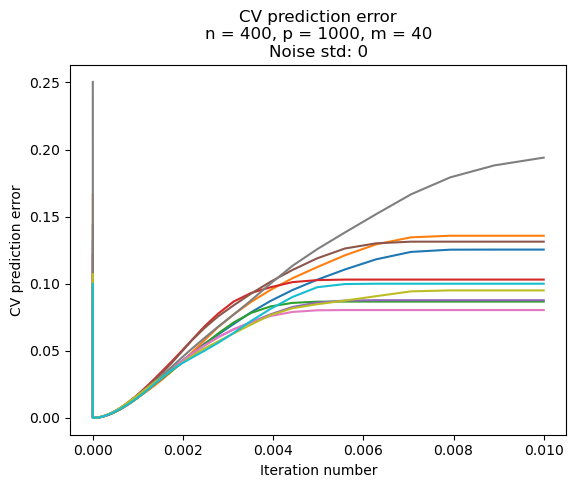

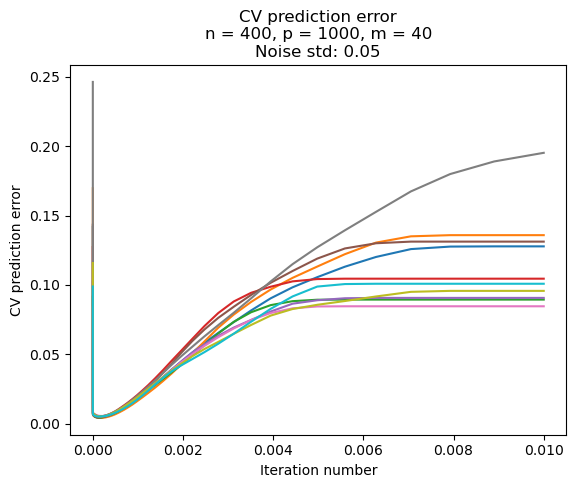

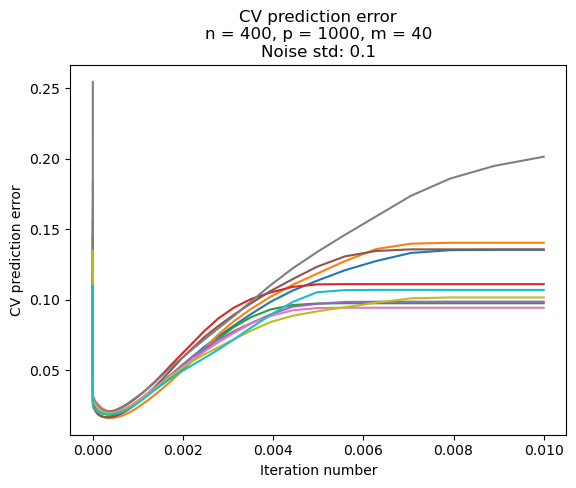

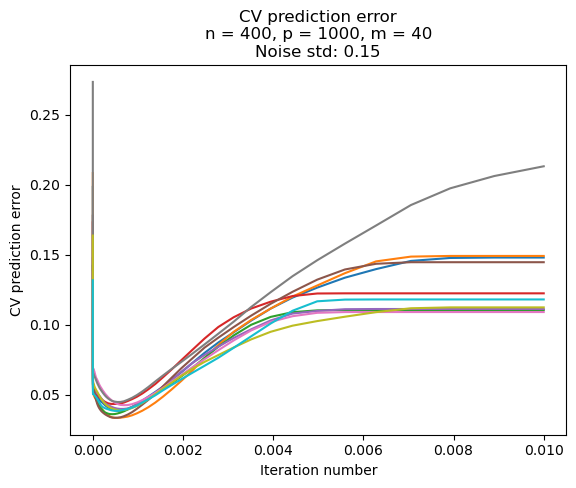

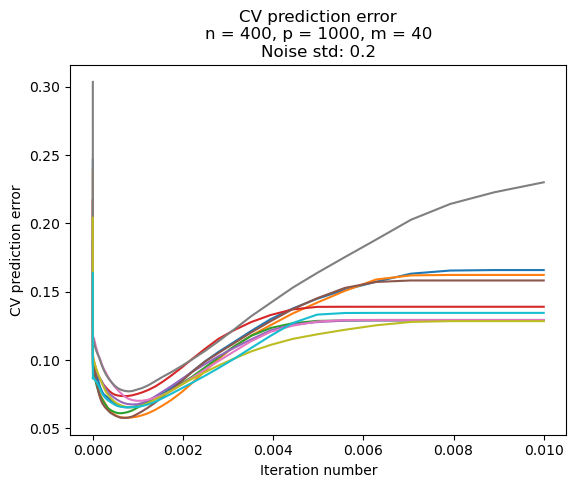

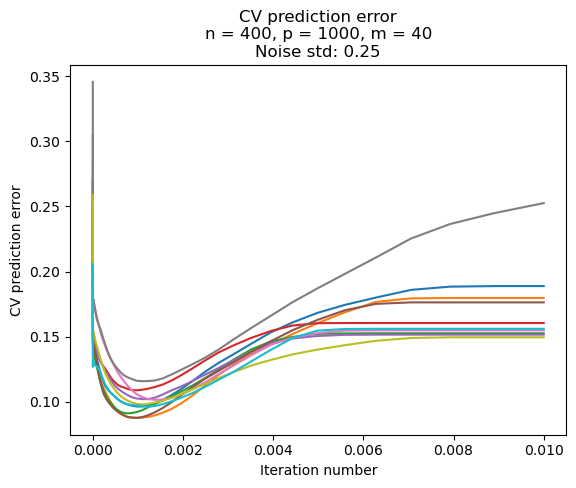

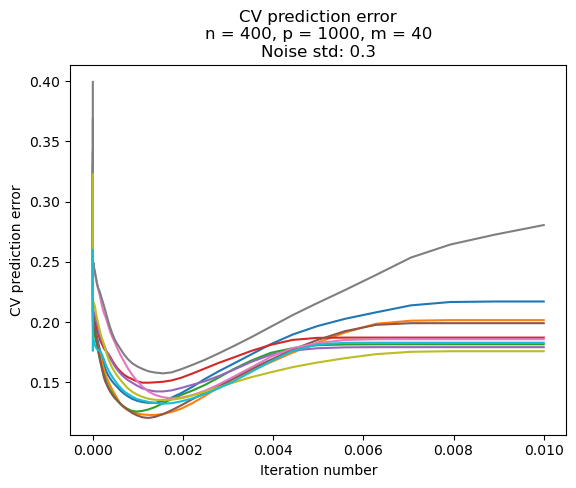

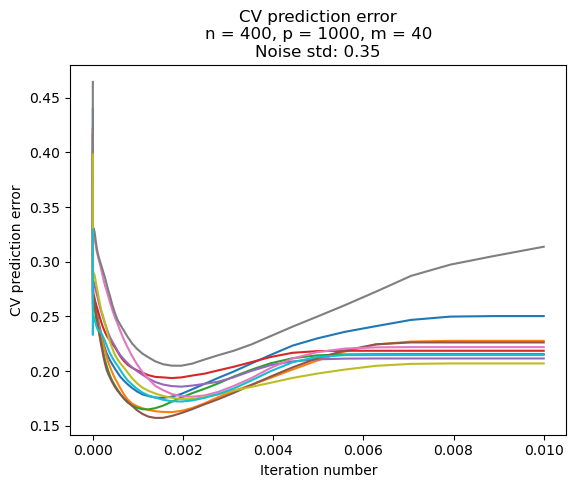

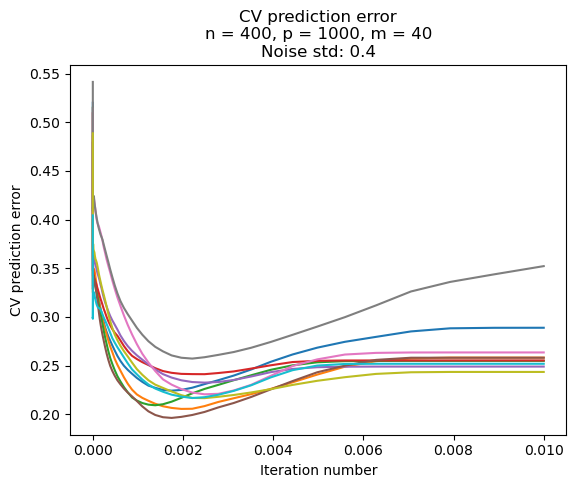

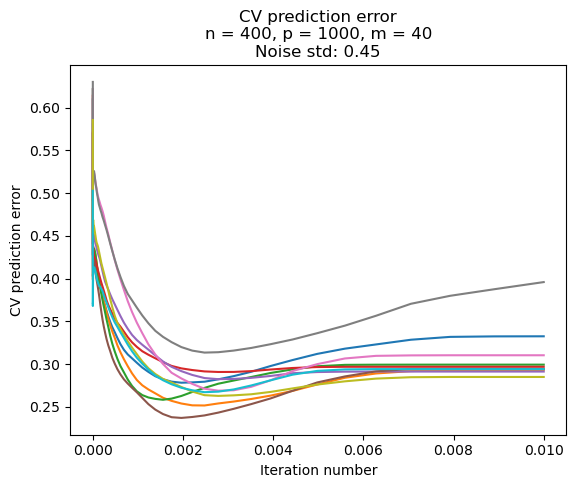

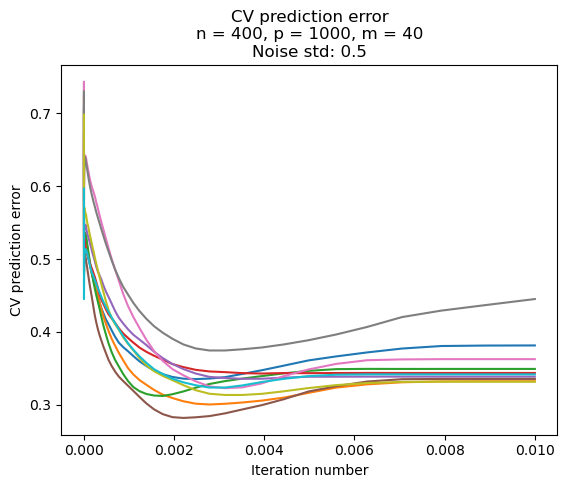

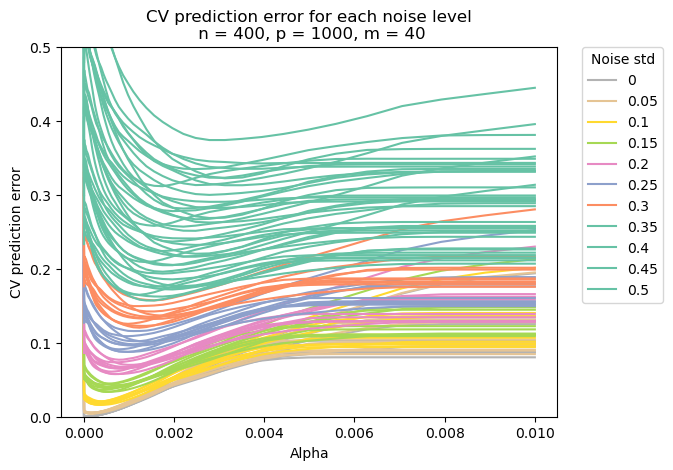

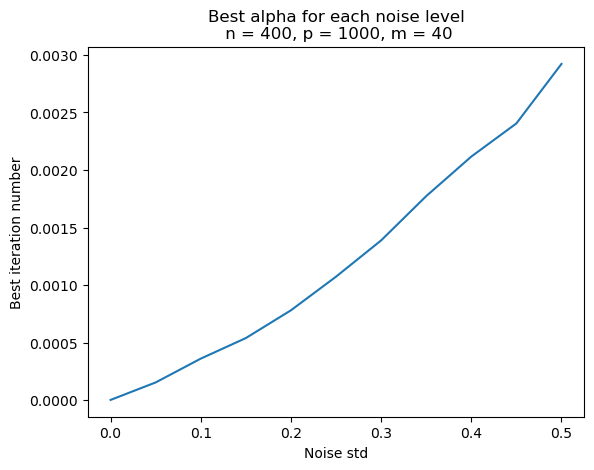

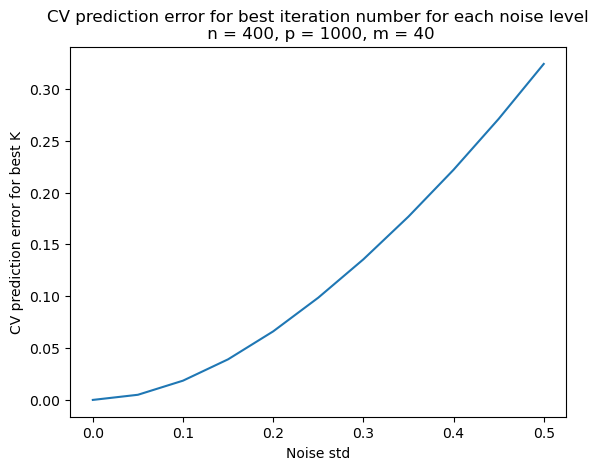

In [23]:
from visualization import makeplots

makeplots(res_log, sep=True, savefig=False)

In [24]:
print(noise_level_lowest_MSE)

[1.0374339607402553e-07, 0.004964559485140537, 0.018577742945636817, 0.03915698805879547, 0.06610117681282962, 0.09859746951955092, 0.13554646948071808, 0.17677306148815686, 0.22191336546287968, 0.270976244296231, 0.3239849946513645]
